<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales-Python/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas UNAM

Fecha: diciembre 2021

In [24]:
# importar librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [25]:
# parámetros del modelo
p1 = 2
k2 = 0.1

In [26]:
# función para calcular las velociades de generación y degradación 
def velocidades(GFP):
    return [p1, k2 * GFP] 

In [29]:
def gillespieGFp(GFP0, tend):
    # lista para guardar los valores de GFP en el tiempo
    GFP = [GFP0]
    # lista para guardar los tiempos en los que ocurren los eventos
    t = [0]
    # usamos un ciclo while porque no sabemos cuantas interaciones vamos a necesitar
    while t[-1] < tend:
        # tomamos el último valor de GFP
        GFP_actual = GFP[-1]
        # calculamos la suma de las velocidades de generación y degradación
        suma_vel = sum(velocidades(GFP_actual))
        # muestreamos el tiempo que vamos a avanzar de una distribución exponencial 
        tau = np.random.exponential(scale=1/suma_vel)
        # damos el paso en el tiempo 
        t.append(t[-1] + tau)

        # generamos un número aleatorio entre 0 y 1 para determinar el evento que ocurrirá
        rand = np.random.uniform(0,1)
        # evento de producción
        if rand * suma_vel > 0 and rand * suma_vel <= p1:
            GFP.append(GFP[-1] + 1)

        # evento de degradación
        else:
            GFP.append(GFP[-1] - 1)
    return [t, GFP]

In [30]:
out = gillespieGFp(0, 100)

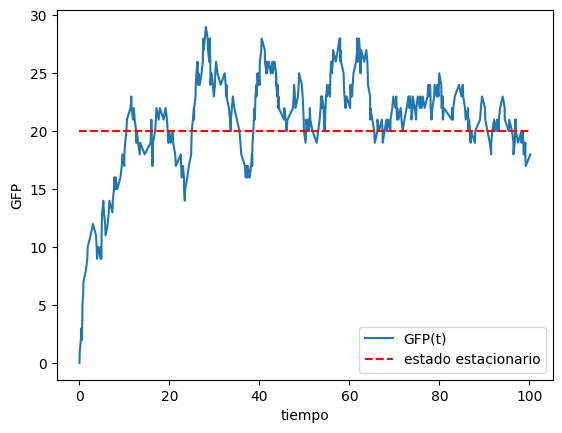

In [31]:
plt.plot(out[0], out[1])
plt.xlabel("tiempo")
plt.ylabel("GFP")
plt.plot(out[0], np.ones_like(out[0])*20, "r--")
plt.legend(["GFP(t)", "estado estacionario"])

## Obtener la concentración final de GFP al realizar varias simulaciones para determinar su distribución

In [32]:
def GFP_final(GFP0, tend):

    out = gillespieGFp(GFP0, tend)

    GFP = out[1]

    return GFP[-1] 

In [33]:
GFP_final(0, 100)

25

In [34]:
N = 1000
GFPs = []
for i in range(N):
    GFPs.append(GFP_final(0, 100))

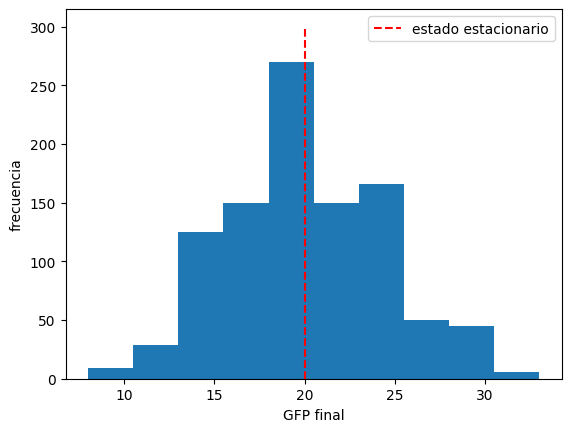

In [45]:
plt.hist(GFPs)
plt.plot([20, 20], [0, 300], "r--")
plt.xlabel("GFP final")
plt.ylabel("frecuencia")
plt.legend(["estado estacionario"])

## Simular con modelo determinista

In [36]:
# modelo del proceso
def modelo(s, t, p):
    GFP = s[0]
    p1 = p[0]
    k2 = p[1]
    dGFP = p1 - k2 * GFP
    return dGFP

In [37]:
# valor de parámetros 
p = [p1, k2]
# condiciones iniciales 
s = [0]
# tiempo de integración
t = np.linspace(0, 100, 1000)

In [38]:
# resolver el modelo
out = odeint(modelo, s, t, args = (p, ))

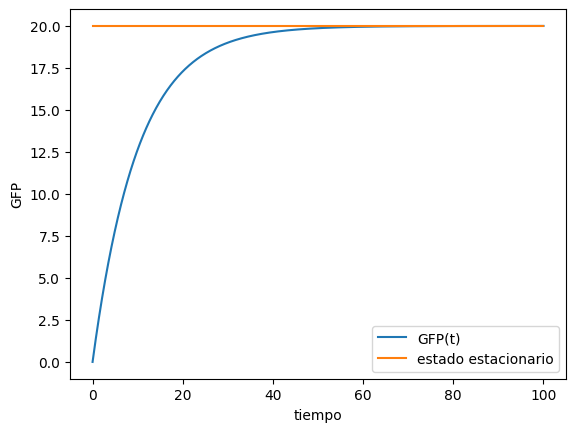

In [39]:
# mostrar resultados 
plt.plot(t, out)
plt.plot(t, np.ones_like(t) * 20)
plt.xlabel("tiempo")
plt.ylabel("GFP")
plt.plot(out[0], np.ones_like(out[0])*20, "r--")
plt.legend(["GFP(t)", "estado estacionario"])

## Ahora empleamos la paquetería en Python

In [40]:
pip install gillespy2

In [41]:
# Numpy is used to set the timespan of the Model.
import numpy as np

# Import the types that'll be needed to define your Model.
from gillespy2.core import (
    Model,
    Species,
    Reaction,
    Parameter
)

"""
Your model is declared and configured as a Python class. As such, the name 
between `class` and `(Model):` can be of your choosing.

For this example we'll be modeling GFP production,
so lets set the name accordingly.
"""
class GFP(Model):
     def __init__(self, parameter_values=None):

            # Intialize the Model with a name of your choosing.
            Model.__init__(self, name="GFP")
            
            """
            Parameters are constant values relevant to the system, such as reaction kinetic rates.
            
            - name: A user defined name for reference.
            - expression: Some constant value.
            """

            p1 = Parameter(name = "p1", expression = 2)
            k2 = Parameter(name = "k2", expression = 0.1)
            
            # Add the Parameters to the Model.
            self.add_parameter([p1, k2])
            
            """
            Species can be anything that participates in or is produced by a reaction channel.
            
            - name: A user defined name for the species.
            - initial_value: A value/population count of species at start of simulation.
            """

            GFP = Species(name = "GFP", initial_value = 0)
            
            # Add the Species to the Model.
            self.add_species([GFP])
            
            """
            Reactions are the reaction channels which cause the system to change over time.
            
            - name: A user defined name for the reaction.
            - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
            - products: A dictionary with reaction products as keys, and number formed per reaction as value.
            - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
            - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
            """

            produccion = Reaction(
                    name = "produccion", 
                    products = {GFP: 1},
                    rate = p1
                )
            
            degradacion = Reaction(
                    name = "degradacion",
                    reactants = {GFP: 1}, 
                    rate = k2
                )
            
            # Add the Reactions to the Model.
            self.add_reaction([produccion, degradacion])
            
            # Use NumPy to set the timespan of the Model.
            self.timespan(np.linspace(0, 100, 101))

In [42]:
# Instantiate your Model.
model = GFP()

In [43]:
"""
Run a stochastic simulation on the Model and store the results in the 'results' variable.
GillesPy2 will use the best solver for the Model if no solver is declared (see below).
"""
results = model.run()

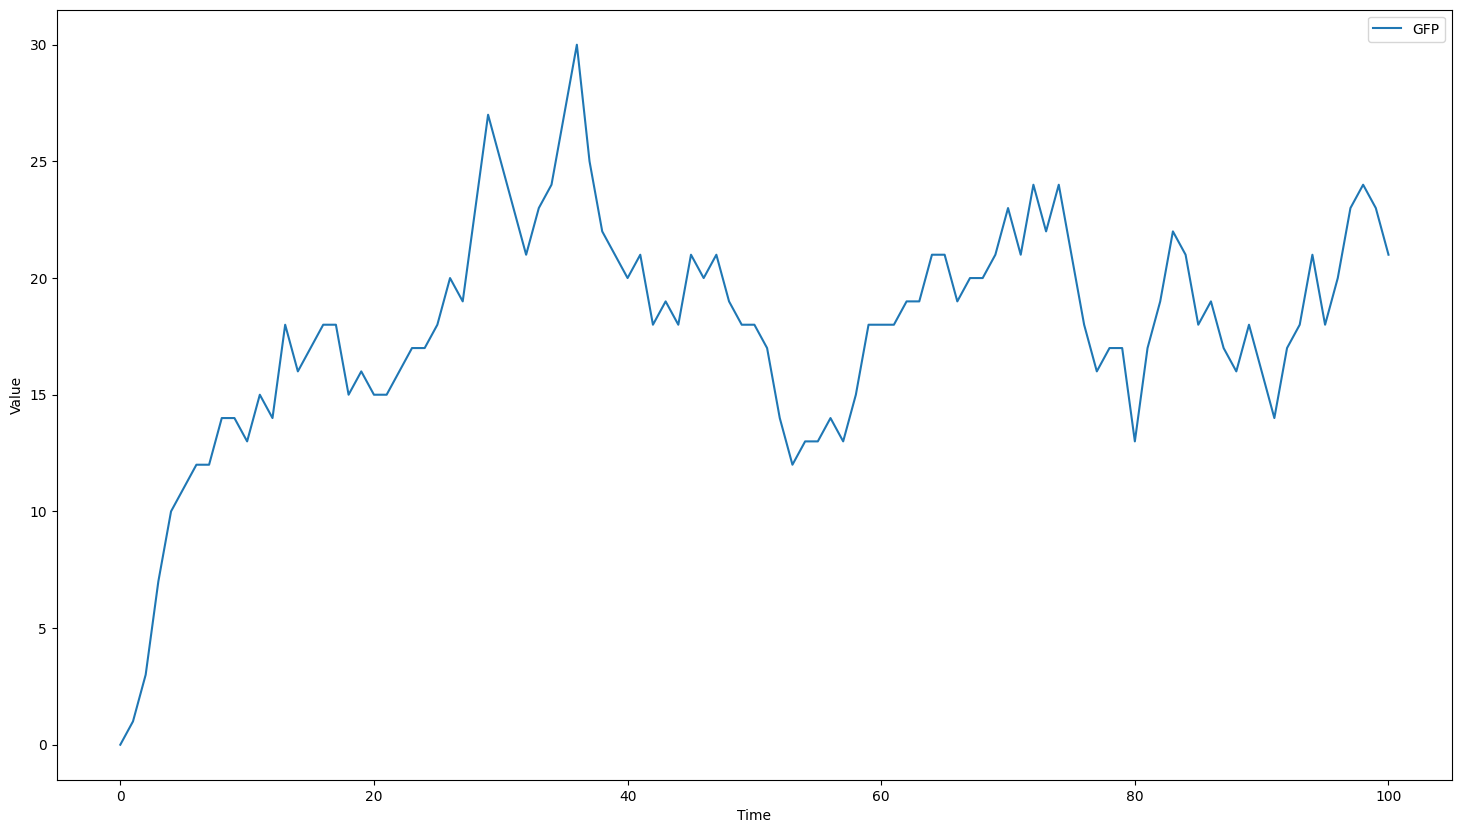

In [44]:
results.plot()

Para más información sobre el paquete gillespy2 pueden revisar el siguiente link 

https://github.com/StochSS/GillesPy2/tree/main/examples 

😄